In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import Levenshtein
import librosa
import matplotlib.pyplot as plt
import MorseCodePy as mcp

In [2]:
train_df = pd.read_csv('train.csv')
train_df.head()

id     message
0  1.opus  03ЩУЫЛПИГХ
1  2.opus  ЪЛТ0ДС6А3Г
2  3.opus   5ЭКЫБЗХЯН
3  4.opus   ЖЫЦОИ68КФ
4  5.opus   32Ю7МЫ ЗЛ

In [3]:
sample_id = 6
message = train_df.iloc[sample_id-1]['message']
message

'7У98ШБ2'

In [4]:
file = f'morse_dataset/{sample_id}.opus'

signal, sr = librosa.load(file, sr=None)
print(signal.shape, sr)

(64000,) 8000


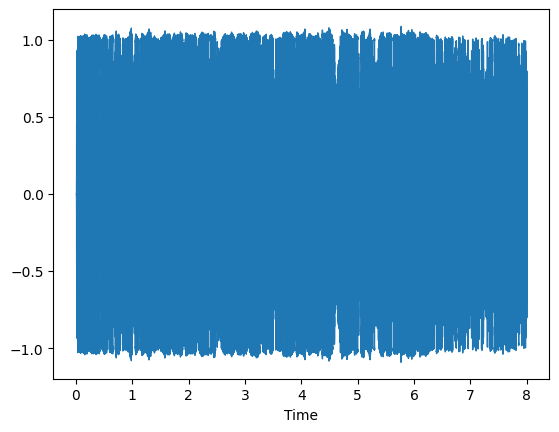

In [5]:
librosa.display.waveshow(signal, sr=sr)

In [6]:
import IPython
display(IPython.display.Audio(signal, rate = sr))

(257, 501)


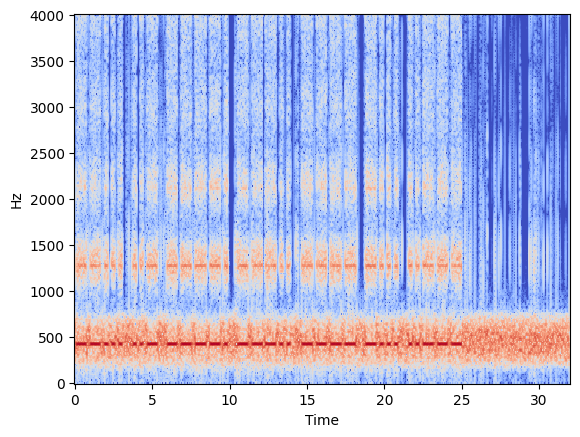

In [7]:
n_fft = 512
D = librosa.stft(signal, n_fft=n_fft)
print(D.shape)
s = librosa.amplitude_to_db(np.abs(D))

librosa.display.specshow(s, sr=sr, x_axis='time', y_axis='linear')

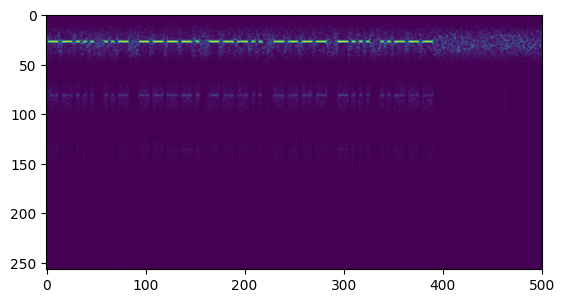

In [8]:
plt.imshow(np.abs(D))

In [9]:
mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc = 64, n_fft=n_fft)

In [10]:
mfccs[:10]

array([[-303.17017   ,  -84.74617   , -110.178185  , ..., -352.14185   ,
        -269.4791    , -144.08722   ],
       [ 168.22806   ,   63.913956  ,   70.47322   , ...,  218.65094   ,
         158.14098   ,   93.52557   ],
       [   5.9630585 ,  -12.996086  ,   -6.9650984 , ...,   61.84111   ,
          37.035744  ,    7.6471667 ],
       ...,
       [ -11.494818  ,  -16.135605  ,   -5.160697  , ...,  -12.077642  ,
           0.46089986,  -18.07821   ],
       [  28.544304  ,   28.10043   ,   20.181837  , ...,   -2.6275396 ,
          10.038401  ,  -10.159119  ],
       [ -18.608553  ,   -8.625409  ,  -16.5153    , ...,   -3.7471647 ,
         -30.099037  ,   -8.745898  ]], shape=(10, 126), dtype=float32)

(64, 501)


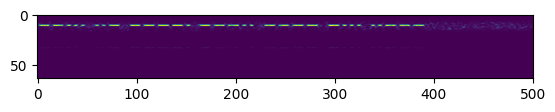

In [11]:
melspectrum = librosa.feature.melspectrogram(y=signal, sr = sr,
                                        	n_mels = 64, n_fft=n_fft, hop_length=n_fft // 4)
print(melspectrum.shape)
plt.imshow(melspectrum)

In [12]:
print(message)
mcp.encode(message, language='russian')

7У98ШБ2


'--... ..- ----. ---.. ---- -... ..---'

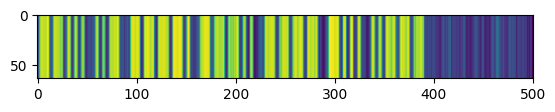

In [13]:
plt.imshow(np.sum(melspectrum, axis=0, keepdims=True) * np.ones((64, 1)))

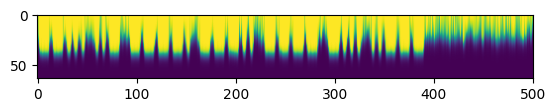

In [14]:
def negative_entropy(spectrogram: np.ndarray, min_temp=0, max_temp=5, out_channels=64):
    # spectrogram.shape = [C, N]
    temperature = np.linspace(min_temp, max_temp, out_channels)[None, None, :]
    exp = np.exp((spectrogram - np.max(spectrogram, axis=0))[:, :, None] / (np.e ** temperature))
    probs = exp / np.sum(exp, axis=0)
    entropy = np.transpose(-np.sum(probs * np.log(probs + 1e-8), axis=0), axes=(1, 0))
    # norm = np.linalg.norm(-entropy, axis=1, keepdims=True)
    return -entropy
    # return -entropy / norm

plt.imshow(negative_entropy(np.abs(D)))

In [15]:
np.min(negative_entropy(np.abs(D)))

np.float64(-5.548884615699369)

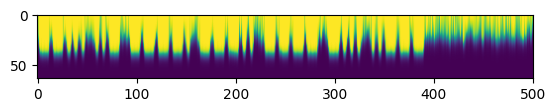

In [16]:
source = np.abs(D)
temperature = np.linspace(0, 5, 64)[None, None, :]
exp = np.exp((source - np.max(source, axis=0))[:, :, None] / (np.e ** temperature))
# exp / np.sum(exp, axis=0, keepdims=True)
# plt.imshow(exp / np.sum(exp, axis=0))
probs = exp / np.sum(exp, axis=0)
# np.sum(probs, axis=0)
entropy = np.transpose(-np.sum(probs * np.log(probs + 1e-8), axis=0), axes=(1, 0))
plt.imshow(-entropy)

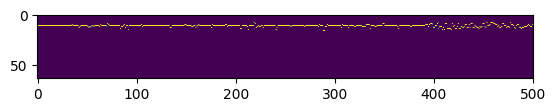

In [17]:
plt.imshow(torch.softmax(torch.as_tensor(melspectrum), dim=0))

## explore

In [18]:
def plot_it(sample_id: int):
	file = f'morse_dataset/{sample_id}.opus'
	signal, sr = librosa.load(file, sr=None)

	n_fft = 512
	D = librosa.stft(signal, n_fft=n_fft)
	spectrogram = np.abs(D)

	melspectrogram = librosa.feature.melspectrogram(y=signal, sr = sr,
												n_mels = 64, n_fft=n_fft, hop_length=n_fft // 4)

	neg_ent = negative_entropy(spectrogram)

	message = train_df.iloc[sample_id-1]['message']
	morse = mcp.encode(message, language='russian')

	print('         ', morse, '         ', message)
	plt.imshow(spectrogram)
	plt.show()
	fig, axs = plt.subplots(3)
	axs[0].imshow(melspectrogram)
	axs[1].imshow(torch.softmax(torch.as_tensor(melspectrogram), dim=0))
	axs[2].imshow(neg_ent)
	plt.show()
	print('         ', morse, '         ', message)
	

          ----- ...-- --.- ..- -.-- .-.. .--. .. --. ....           03ЩУЫЛПИГХ


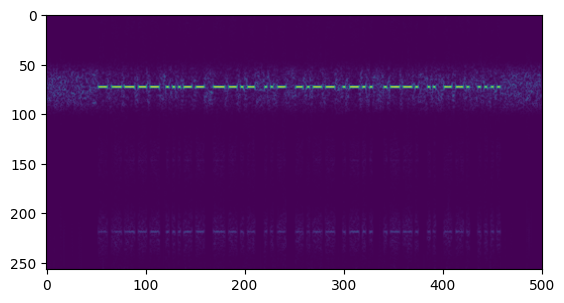

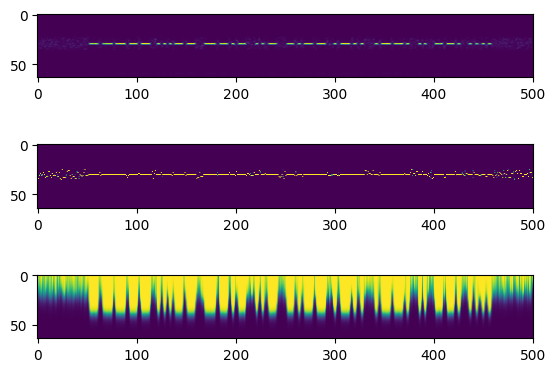

          ----- ...-- --.- ..- -.-- .-.. .--. .. --. ....           03ЩУЫЛПИГХ


In [19]:
plot_it(1)

          --.-- .-.. - ----- -.. ... -.... .- ...-- --.           ЪЛТ0ДС6А3Г


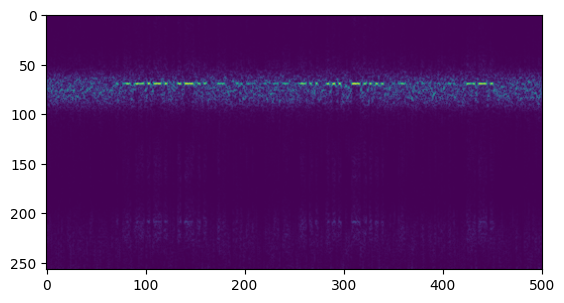

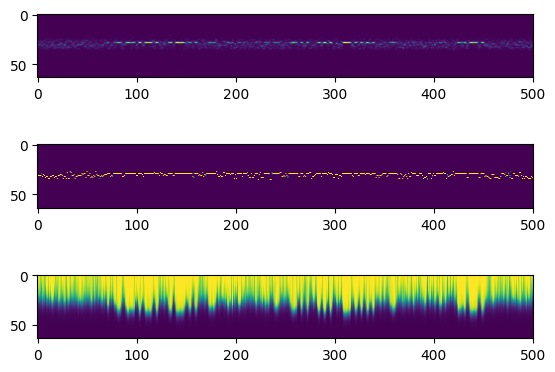

          --.-- .-.. - ----- -.. ... -.... .- ...-- --.           ЪЛТ0ДС6А3Г


In [20]:
plot_it(2)

          ..- --.. --- --.. * --. ---..           УЗОЗ#Г8


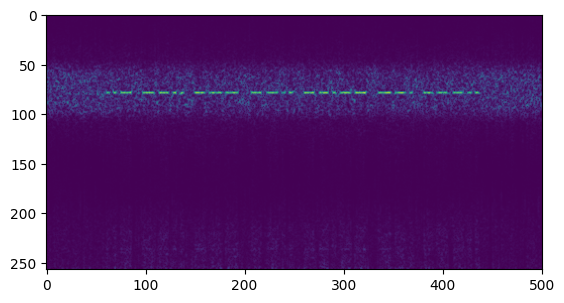

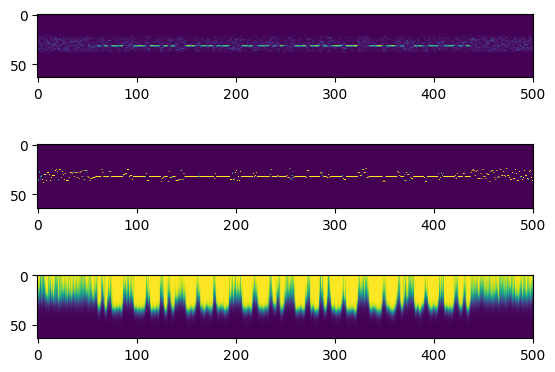

          ..- --.. --- --.. * --. ---..           УЗОЗ#Г8


In [21]:
plot_it(7)

          -.. / ...- ..... / - .-. ....- --.-- .. -.... --- .....           Д Ж5 ТР4ЪИ6О5


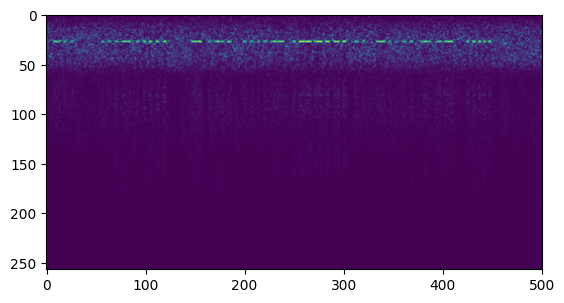

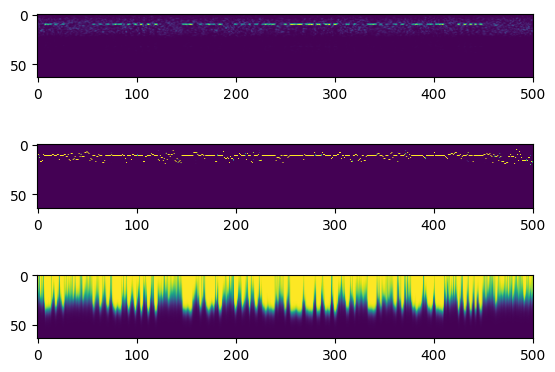

          -.. / ...- ..... / - .-. ....- --.-- .. -.... --- .....           Д Ж5 ТР4ЪИ6О5


In [22]:
plot_it(1474)

          --.-- ..-.. ---.. -.. ..--- -- --.. .-           ЪЭ8Д2МЗА


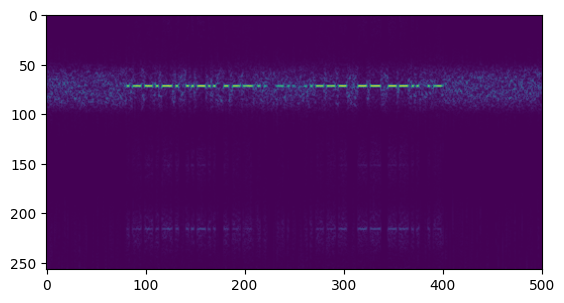

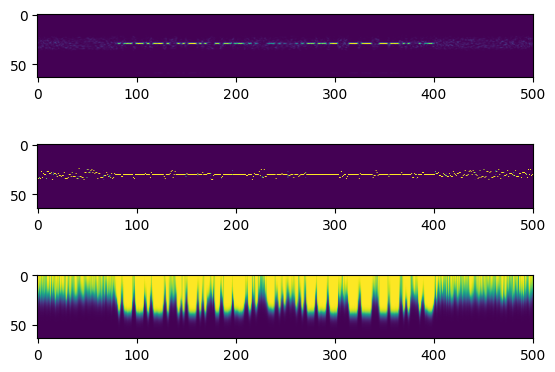

          --.-- ..-.. ---.. -.. ..--- -- --.. .-           ЪЭ8Д2МЗА


In [23]:
plot_it(30000)

          ..... .... -.- ..... .-- .--. .. --... - .-.- ..--           5ХК5ВПИ7ТЯЮ


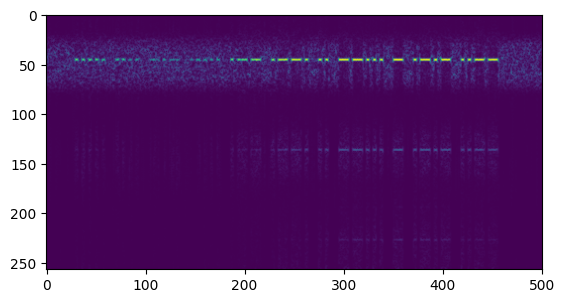

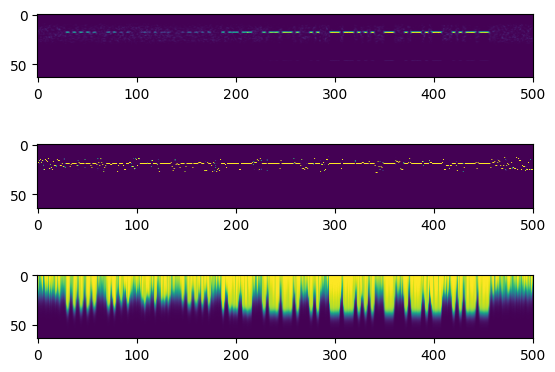

          ..... .... -.- ..... .-- .--. .. --... - .-.- ..--           5ХК5ВПИ7ТЯЮ


In [24]:
plot_it(5432)

          -.-. - -- -.... .--- --.--           ЦТМ6ЙЪ


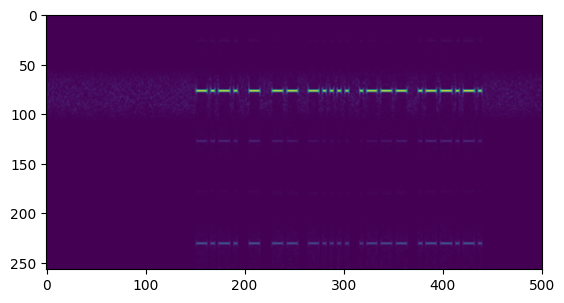

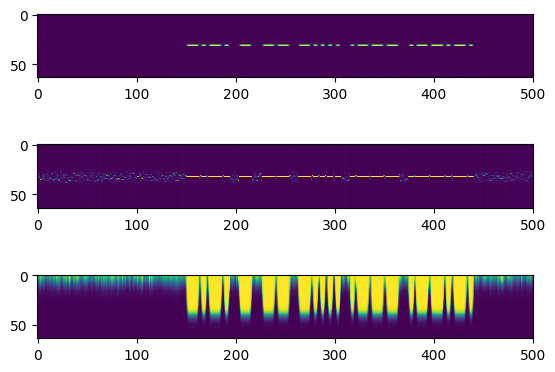

          -.-. - -- -.... .--- --.--           ЦТМ6ЙЪ


In [25]:
plot_it(17341)

          -.- .-.- ----- --... ---- .-.. -.           КЯ07ШЛН


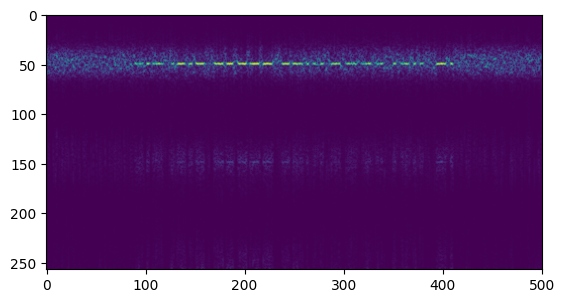

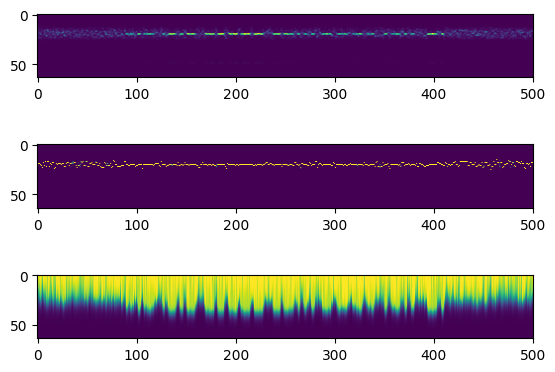

          -.- .-.- ----- --... ---- .-.. -.           КЯ07ШЛН


In [26]:
plot_it(347)

          --.. .-- .- ---. ....- ..... ..- -..- .           ЗВАЧ45УЬЕ


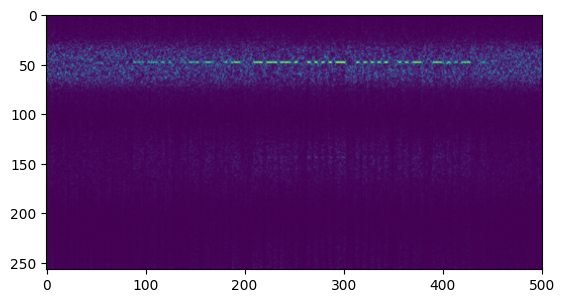

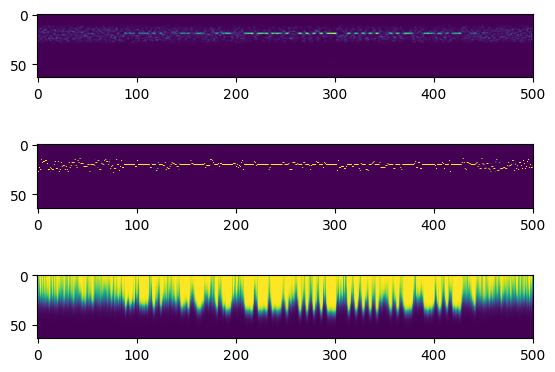

          --.. .-- .- ---. ....- ..... ..- -..- .           ЗВАЧ45УЬЕ


In [27]:
plot_it(26473)

          .. .---- .-. .-- -.- -- ..... --.- / .----           И1РВКМ5Щ 1


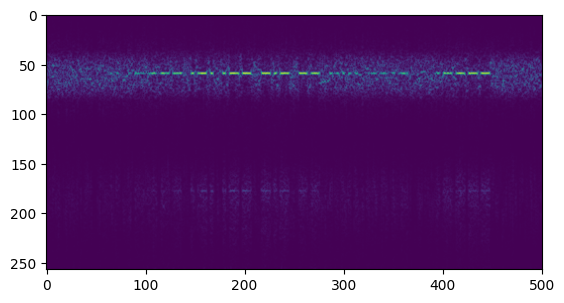

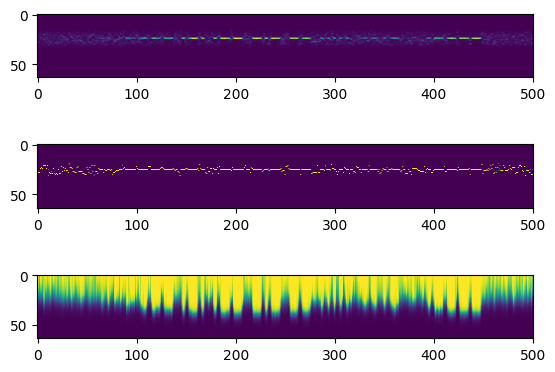

          .. .---- .-. .-- -.- -- ..... --.- / .----           И1РВКМ5Щ 1


In [28]:
plot_it(8642)

          ----- .. . ..-- ... -... .. .-. ..-. ...- / ...           0ИЕЮСБИРФЖ С


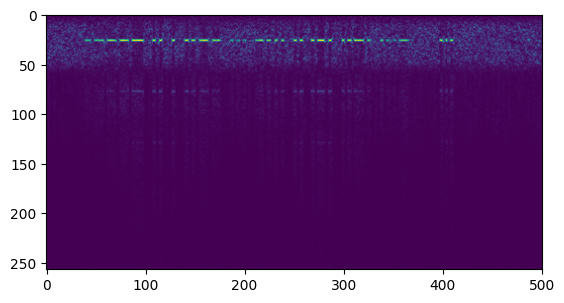

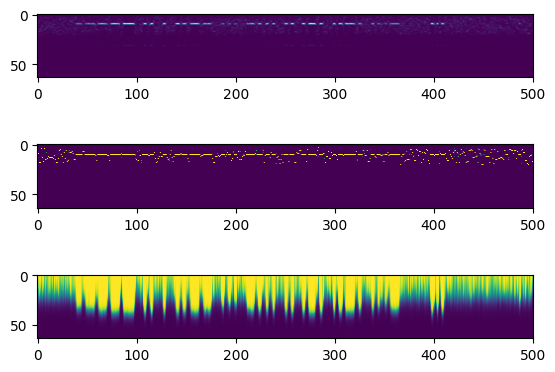

          ----- .. . ..-- ... -... .. .-. ..-. ...- / ...           0ИЕЮСБИРФЖ С


In [29]:
plot_it(29778)

### what the hell is \#

          -. ..--- --.- .-. --.- / * ... -- .-..           Н2ЩРЩ #СМЛ


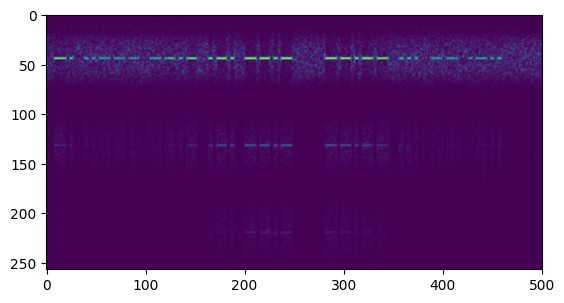

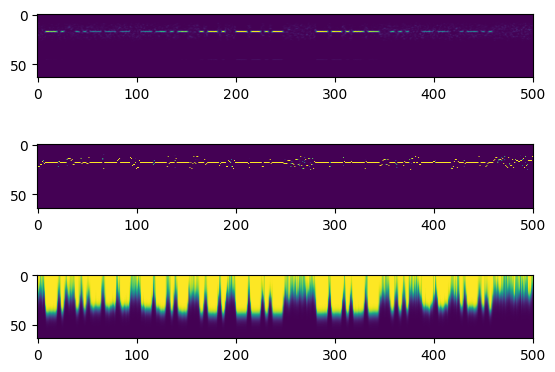

          -. ..--- --.- .-. --.- / * ... -- .-..           Н2ЩРЩ #СМЛ


In [40]:
plot_it(29774)

          * .---- / --... -... -----           #1 7Б0


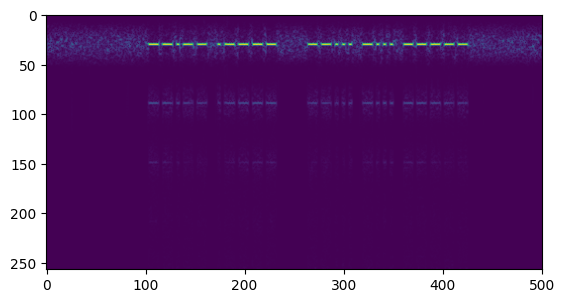

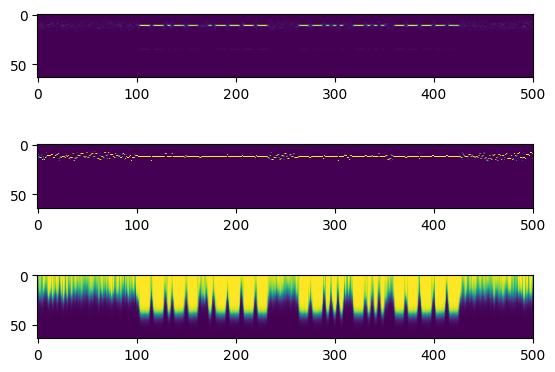

          * .---- / --... -... -----           #1 7Б0


In [41]:
plot_it(22448)

          --... .---- ..... -. .---- --... / *           715Н17 #


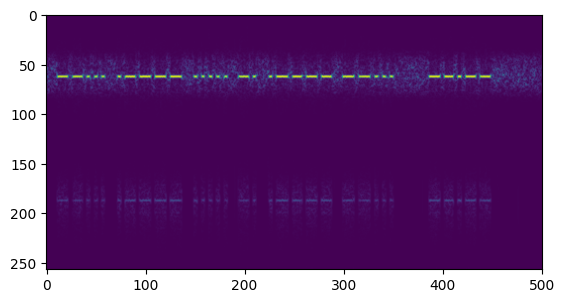

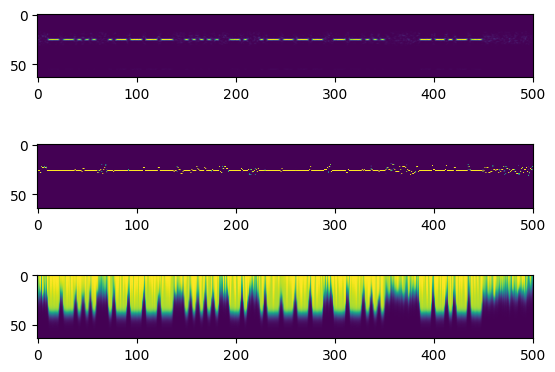

          --... .---- ..... -. .---- --... / *           715Н17 #


In [42]:
plot_it(14656)

          * --.-- -.- --... * / ...--           #ЪК7# 3


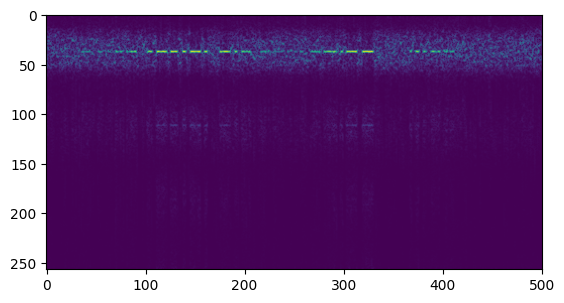

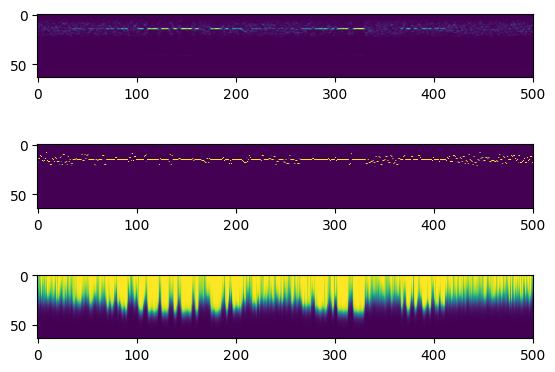

          * --.-- -.- --... * / ...--           #ЪК7# 3


In [43]:
plot_it(14691)

          --.-- ..- ---.. / * - --- ..- --. -.           ЪУ8 #ТОУГН


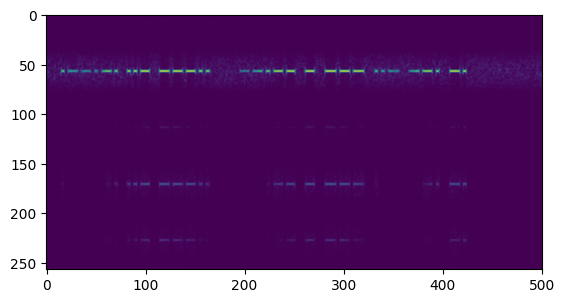

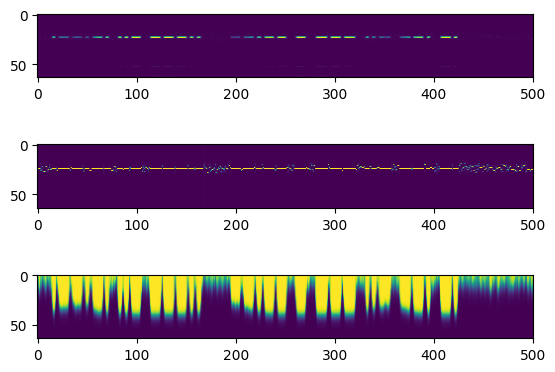

          --.-- ..- ---.. / * - --- ..- --. -.           ЪУ8 #ТОУГН


In [44]:
plot_it(14783)

the heck happen to 'Ъ' ?

          .-.- --.. .-.. / ..-- --- ---- --.-- .           ЯЗЛ ЮОШЪЕ


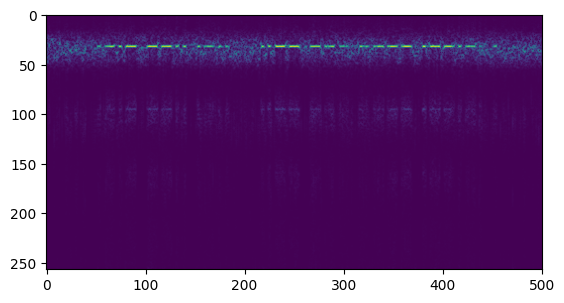

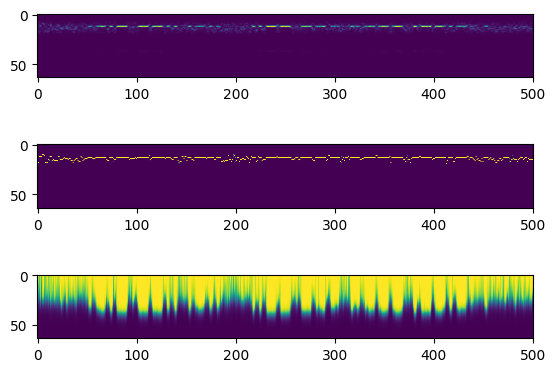

          .-.- --.. .-.. / ..-- --- ---- --.-- .           ЯЗЛ ЮОШЪЕ


In [45]:
plot_it(10)

          . / - --.- -.. .--. -.- ..-- .-- .. -. --.-- .-           Е ТЩДПКЮВИНЪА


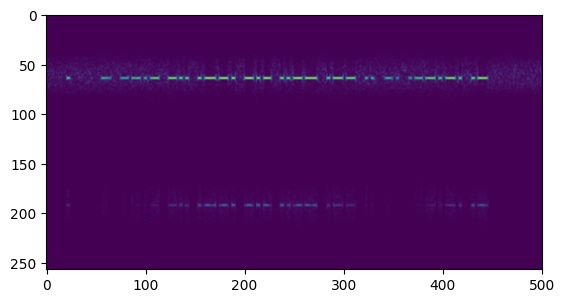

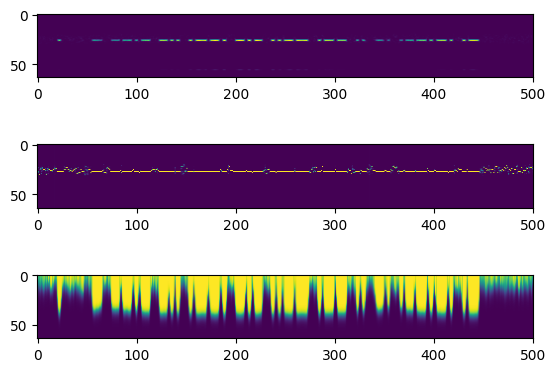

          . / - --.- -.. .--. -.- ..-- .-- .. -. --.-- .-           Е ТЩДПКЮВИНЪА


In [46]:
plot_it(8740)

so actual code for 'Ъ' is .--.-.

now i'll have to check each letter 

In [63]:
' #0123456789АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ'
'=\====================================\====='

'=\\====================================\\====='

### text encoding

<Axes: >

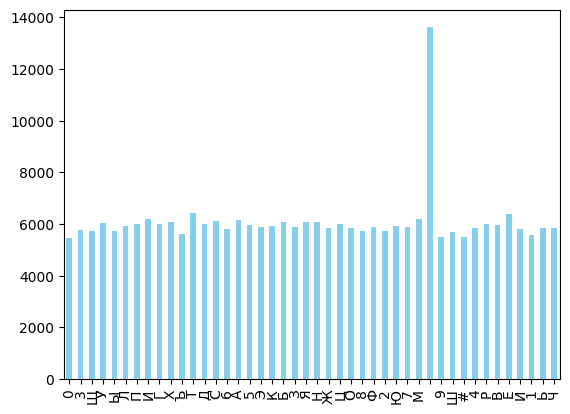

In [30]:
from collections import Counter

counter = Counter(''.join(train_df['message']))
counts = pd.DataFrame({'Counter': counter})['Counter']
# pd.DataFrame({'counts': list(''.join(train_df['message']))}).value_counts()
counts.plot(kind='bar', color='skyblue')


In [61]:
# thats actually great
''.join(train_df['message']).find('  ')

-1

In [ ]:
def encode_to_morse(text: str, remove_separator_pad=False):
    encoded = mcp.encode(text, language='russian')
    sharp_code = '--.--'    # #
    hard_code = '.--.-.'
    common_hard_code = '--.--'  # Ъ
    encoded = encoded.replace(common_hard_code, hard_code)
    encoded = encoded.replace('*', sharp_code)

    if remove_separator_pad:
        encoded = encoded.replace('/ ', '/')
        encoded = encoded.replace(' /', '/')
    return encoded

In [67]:
all_symbols = ''.join(counter.keys())
print(all_symbols)
all_encodings = encode_to_morse(all_symbols)
print(all_encodings)
len(set(all_encodings.split(' '))) == len(all_symbols)

03ЩУЫЛПИГХЪТДС6А5ЭКБЗЯНЖЦО8Ф2Ю7М 9Ш#4РВЕЙ1ЬЧ
----- ...-- --.- ..- -.-- .-.. .--. .. --. .... .--.-. - -.. ... -.... .- ..... ..-.. -.- -... --.. .-.- -. ...- -.-. --- ---.. ..-. ..--- ..-- --... -- / ----. ---- --.-- ....- .-. .-- . .--- .---- -..- ---.


True

In [76]:
def decode_from_morse(morse: str, separator_pads_removed=False):
    sharp_code = '--.--'    # #
    hard_code = '.--.-.'
    common_hard_code = '--.--'  # Ъ
    # # -> ? -> #
    question_mark_code = '..--..'   # ?
    code = morse.replace(sharp_code, question_mark_code)
    code = code.replace(hard_code, common_hard_code)
    if separator_pads_removed:
        code = code.replace('/', ' / ').strip(' ')
    text = mcp.decode(code, language='russian')
    text = text.replace('?', '#').upper()
    return text

In [78]:
decode_from_morse(all_encodings) == all_symbols

True

In [95]:
class Vectorizer:
    def __init__(self):
        self.text_to_nums = {
            ' ': 0,
            '.': 1,
            '-': 2,
            '/': 3,
            }
        self.nums_to_text = dict([(v, k) for k, v in self.text_to_nums.items()])
        pass

    def to_tensor(self, text: str):
        return torch.tensor([self.text_to_nums[ch] for ch in text])
    
    def from_tensor(self, tensor: torch.Tensor):
        assert tensor.ndim == 1
        return ''.join([self.nums_to_text[num.item()] for num in tensor])

In [99]:
vec_maker = Vectorizer()
vec = vec_maker.to_tensor(all_encodings)
print(len(vec), len(all_encodings))
unvec = vec_maker.from_tensor(vec)
unvec == all_encodings

208 208


True